In [21]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [10]:
def format_number(num):
    """
    Converts a number into a more readable format, using K for thousands, M for millions, etc.
    Args:
    - num: The number to format.
    
    Returns:
    - A formatted string representing the number.
    """
    if num >= 1e9:
        return f'{num/1e9:.1f}B'
    elif num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.1f}K'
    else:
        return str(num)

In [57]:
!grep MCH ../../results/gwas/raw/release1.1/UKBB_94traits_release1.traits

UKBB	MCH	Mean corpuscular hemoglobin	30050	351324	NA	NA
UKBB	MCHC	Mean corpuscular hemoglobin concentration	30060	351321	NA	NA


In [58]:
!grep eGFR ../../results/gwas/raw/release1.1/UKBB_94traits_release1.traits

UKBB	eGFR	Estimated glomerular filtration rate (serum creatinine)	eGFR based on serum creatinine (30700) using the CKD-EPI formula	345067	NA	NA
UKBB	eGFRcys	Estimated glomerular filtration rate (cystain C)	eGFR based on cystain C (30720) using the CKD-EPI formula	345219	NA	NA


In [54]:
trait_renaming = pd.read_csv(
    "../../results/gwas/raw/release1.1/UKBB_94traits_release1.traits", sep="\t",
).set_index("trait")["description"].to_dict()
trait_renaming = {}  # override
trait_renaming

{}

In [55]:
consequence_renaming = {
    "missense_variant": "missense",
    "non_coding_transcript_exon_variant": "ncRNA",
    "3_prime_UTR_variant": "3' UTR",
    "5_prime_UTR_variant": "5' UTR",
}

subset_renaming = {**trait_renaming, **consequence_renaming}

In [51]:
subsets = [
    "all",

#    "nonexonic",
#    "missense_variant",
#    "non_coding_transcript_exon_variant",
#    "3_prime_UTR_variant",
#    "5_prime_UTR_variant",

    "Height",
    "MCV",
    "MCH",
    "Mono",
    "Plt",
    "eBMD",
    "HbA1c",
    "RBC",
    "ALP",
    "IGF1",
    "HDLC",
    "Eosino",
    "LDLC",
    "SHBG",
    "AG",
    "Lym",
    "Hb",
    "GGT",
    "eGFRcys",
    "ApoA",
    "WBC",
    "eGFR",
    "TP",
]

models = [
    "Enformer_L2",
    "Borzoi_L2",
    "CADD",
    "GPN-MSA",
    "Enformer_L2+GPN-MSA+CADD",
]

classifier = "LogisticRegression"

palette = {model: f"C{i}" for i, model in enumerate(models)}

dfs = []
sample_size = {}

base_dir = f"../../results/dataset/gwas_matched_9"
V = pd.read_parquet(f"{base_dir}/test.parquet")

for subset in tqdm(subsets):
    s = pd.read_parquet(f"{base_dir}/subset/{subset}.parquet")
    V_s = s.merge(V, on=["chrom", "pos", "ref", "alt"], how="left")
    sample_size[subset] = V_s.label.sum(), (~V_s.label).sum()
    for model in models:
        df = pd.read_csv(f"{base_dir}/metrics_by_chrom_weighted_average/{subset}/{model}.{classifier}.chrom.csv")
        df.Model = model
        df["subset"] = subset
        dfs.append(df)
df = pd.concat(dfs)
#df["n_hits"] = df.trait.map(n_hits)
df

  0%|   | 0/24 [00:00<?, ?it/s]

100%|█| 24/24 [00:01<00:00, 21.


,Model,AUPRC,subset
0,Enformer_L2,0.291667,all
0,Borzoi_L2,0.281835,all
0,CADD,0.259164,all
0,GPN-MSA,0.273633,all
0,Enformer_L2+GPN-MSA+CADD,0.362071,all
...,...,...,...
0,Enformer_L2,0.444450,TP
0,Borzoi_L2,0.480790,TP
0,CADD,0.457521,TP
0,GPN-MSA,0.331127,TP


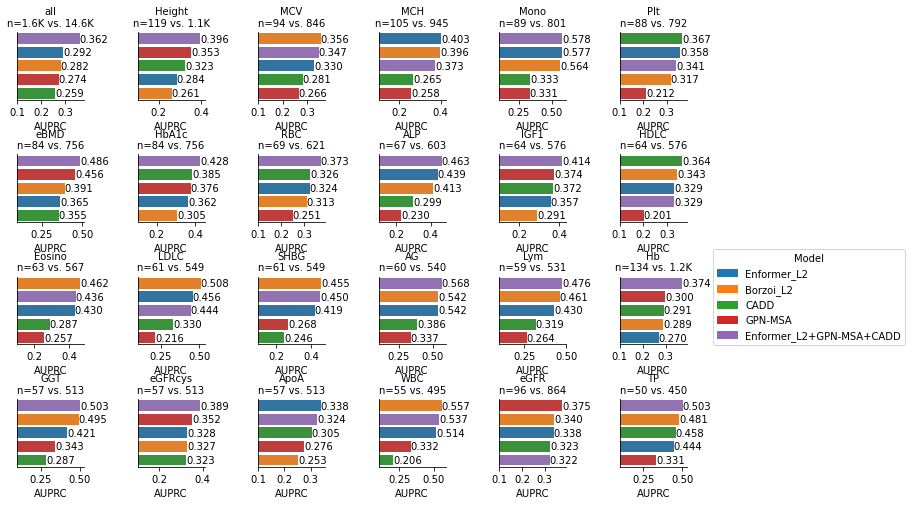

In [56]:
#nrows, ncols = 2, 3
nrows, ncols = 4, 6
width, height = 2, 2
wspace, hspace = 0.8, 0.8
metric = "AUPRC"

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, sharex=False, sharey=False,
    figsize=(width*ncols, height*nrows), squeeze=False,
    gridspec_kw={'wspace': wspace, 'hspace': hspace},
)

for subset, ax in zip(subsets, axes.flat):
    df_s = df[df.subset==subset].sort_values(metric, ascending=False)
    n_pos, n_neg = sample_size[subset]

    if metric == "AUROC":
        baseline = 0.5
    elif metric == "AUPRC":
        baseline = n_pos / (n_pos + n_neg)
    elif metric == "Odds ratio":
        baseline = 1

    g = sns.barplot(
        data=df_s,
        y="Model",
        x=metric,
        palette=palette,
        ax=ax,
    )
    sns.despine()
    sample_size_str = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
    subtitle = f"{subset_renaming.get(subset, subset)}\n{sample_size_str}"
    g.set_title(subtitle, fontsize=10)
    g.set(
        xlim=baseline,
        ylabel="",
        yticks=[],
    )

    for bar, model in zip(g.patches, df_s.Model):
        text = f'{bar.get_width():.3f}'
        g.text(
            max(bar.get_width(), baseline),  # X position, here at the end of the bar
            bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
            text,  # Text to be displayed, formatted to 3 decimal places
            va='center'  # Vertical alignment
        )

plt.legend(
    handles=[mpatches.Patch(color=palette[model], label=model) for model in models],
    bbox_to_anchor=(1.4, 3.2),
    loc='upper left', borderaxespad=0.,
    title="Model",
)

In [26]:
def weighted_average(df):
    weights = df["n_hits"] / df["n_hits"].sum()
    return (df.AUPRC * weights).sum()

df_w = (
    df.groupby("Model").apply(weighted_average).rename("AUPRC")
    .sort_values(ascending=False).to_frame().reset_index()
)
df_w

,Model,AUPRC
0,Enformer_L2+GPN-MSA+CADD,0.343652
1,Borzoi_L2+GPN-MSA+CADD,0.336998
2,Borzoi_L2,0.300357
3,Enformer_L2,0.294627
4,GPN-MSA,0.294354
5,CADD,0.290685


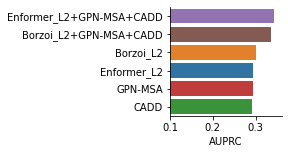

In [29]:
plt.figure(figsize=(2,2))
g = sns.barplot(
    data=df_w,
    y="Model",
    x="AUPRC",
    order=df_w.sort_values("AUPRC", ascending=False).Model,
    palette=palette,
)
g.set(
    ylabel="",
    xlim=0.1,
)
sns.despine();

In [17]:
df.groupby("Model").AUPRC.mean().sort_values(ascending=False)

Model
Enformer_L2+GPN-MSA+CADD    0.344906
Borzoi_L2+GPN-MSA+CADD      0.336992
Borzoi_L2                   0.309807
GPN-MSA                     0.304169
Enformer_L2                 0.300152
CADD                        0.294261
Name: AUPRC, dtype: float64

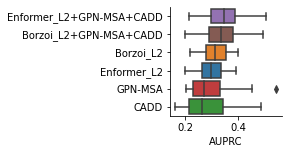

In [18]:
plt.figure(figsize=(2,2))
g = sns.boxplot(
    data=df,
    y="Model",
    x="AUPRC",
    order=df.groupby("Model").AUPRC.median().sort_values(ascending=False).index,
    palette=palette,
)
g.set(
    ylabel="",
)
sns.despine();

In [13]:
#plt.figure(figsize=(2,2))
#g = sns.boxplot(
#    data=best.query('n_hits >= 30'),
#    y="model",
#    x="AUPRC",
#    order=best.query('n_hits >= 30').groupby("model").AUPRC.median().sort_values(ascending=False).index,
#    palette=palette,
#)
#g.set(
#    ylabel="",
#)
#sns.despine();

In [14]:
wins = df.groupby("trait").apply(lambda x: x.sort_values("AUPRC", ascending=False).Model.iloc[0]).rename("winner").to_frame().reset_index()
wins["n_hits"] = wins.trait.map(n_hits)
wins

,trait,winner,n_hits
0,BMD-HT,GPN-MSA,195
1,BMI,GPN-MSA,57
2,CD,Borzoi_L2,83
3,Glucose,CADD,33
4,HDL,Borzoi_L2,161
5,HTN,GPN-MSA,41
6,HbA1c,Borzoi_L2,80
7,Height,CADD,372
8,IBD,Borzoi_L2,112
9,LDL,Borzoi_L2,55


<Axes: xlabel='count', ylabel='winner'>

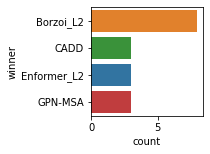

In [15]:
plt.figure(figsize=(2,2))
sns.countplot(
    data=wins,
    y="winner",
    order=wins.groupby("winner").trait.count().sort_values(ascending=False).index,
    palette=palette,
)

In [9]:
wins[wins.winner=="GPN-MSA"]

,trait,winner,n_hits
1,BMI,GPN-MSA,57


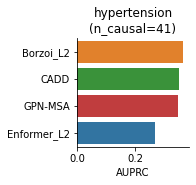

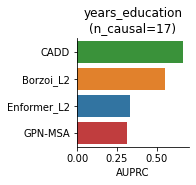

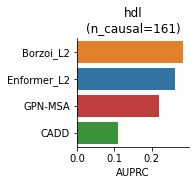

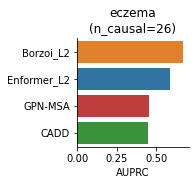

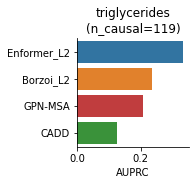

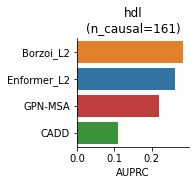

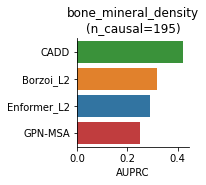

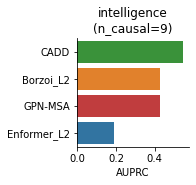

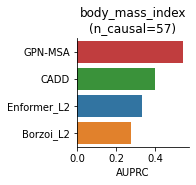

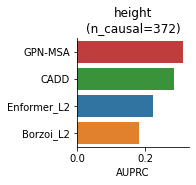

In [16]:
for trait in df.trait.sample(n=10, random_state=42):
    plt.figure(figsize=(2,2))
    g = sns.barplot(
        data=df[df.trait==trait],
        y="Model",
        x="AUPRC",
        order=df[df.trait==trait].sort_values("AUPRC", ascending=False).Model,
        palette=palette,
    )
    g.set(
        ylabel="",
        title=trait_renaming[trait] + f"\n(n_causal={n_hits[trait]})",
    )
    sns.despine();
    plt.show()